### Import packages

In [1]:
import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import *
from PREDICT.Metrics import *
from PREDICT.Triggers import *
from PREDICT.Plots import *
import numpy as np
import pandas as pd
from datetime import timedelta
import statistics
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

import warnings
warnings.filterwarnings('ignore')

## Comparing Methods to Detect Temporal Drift

In this notebook, four methods to detect temporal drift are compared:

1) Regular model testing
2) Statistical process control
3) Static threshold
4) Bayesian variable relative change


<img src="..\docs\images\detect_methods.png" alt="Methods used to detect temporal drift" width="400">


These methods are compared for four scenarios:

1) Fast predictor change - COVID pandemic
2) Slow predictor change - population-based BMI increase
3) Outcome drift - change in prevalence of myocardial infarctions
4) Multivariate drift - the importance of BMI increases whilst age is deemed less important by models


### Interactive plot to show the variables: `switch time`, `drop size` and `time to detection/gap`

In [2]:
def plot_data(switch_time, drop_perc, gap):
    time = np.linspace(0, 10, 100)
    predictor = np.ones_like(time) * 10  # Initial horizontal line

    drop_size = predictor.max() * drop_perc / 100  # Calculate the drop size based on percentage
    
    # Apply the drop effect over the period from switch_time to switch_time + gap
    drop_start = switch_time
    drop_end = switch_time + gap
    
    # Gradual drop over the duration of gap
    drop_mask = (time >= drop_start) & (time <= drop_end)
    predictor[drop_mask] -= (drop_size / gap) * (time[drop_mask] - drop_start)
    
    predictor[time > drop_end] -= drop_size  # Maintain the lower level after drop completion

    plt.figure(figsize=(8, 5))
    plt.annotate('', xy=(drop_start, min(predictor)), xytext=(drop_end, min(predictor)), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f"Time to detect: {gap:.1f} years", xy=(drop_start + gap / 2, predictor.min()-0.5), fontsize=8, ha='center', color='red')

    plt.annotate('', xy=(0, max(predictor)+0.3), xytext=(switch_time, max(predictor)+0.3), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f"Switch time: {switch_time:.1f} years", xy=(switch_time / 2, predictor.max()+0.5), fontsize=8, ha='center')

    plt.annotate('', xy=(switch_time+gap, min(predictor)), xytext=(switch_time+gap, max(predictor)), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f"Drop size: {drop_size:.1f}", xy=(switch_time+gap+1, (predictor.max()+predictor.min())/2), fontsize=8, ha='center')
    
    plt.plot(time, predictor, label="Predictor")
    plt.axvline(switch_time, color='r', linestyle='--', label="Switch Time (t)")
    plt.axvline(switch_time+gap, color='green', linestyle='--', label="Time when Model Detected Change")
    plt.xlabel("Time (TE) [1, 10 years]")
    plt.ylabel("Predictor (k)")
    plt.ylim(0, 15)  # Set y-axis limits for better visibility
    plt.legend()
    plt.grid()
    plt.show()

# Sliders to control parameters
interact(plot_data,
        switch_time=FloatSlider(min=0, max=10, step=1, value=2, description="Switch Time (t)"),
        drop_perc=FloatSlider(min=-40, max=90, step=10, value=15, description="Drop Size (%)"),
        gap=FloatSlider(min=0.1, max=5, step=0.1, value=1, description="Gap (g)"))

interactive(children=(FloatSlider(value=2.0, description='Switch Time (t)', max=10.0, step=1.0), FloatSlider(v…

<function __main__.plot_data(switch_time, drop_perc, gap)>

### Create fake COVID data for fast predictor change

In [9]:
mydict = {
    'date': list(),
    'outcome': list(),
    'prediction': list(),
    'age': list(),
    'systolic_bp': list(),
    'flu_symptoms': list()
}

# Set random seed for reproducibility
np.random.seed(42)
num_patients = 20

# Define date range and COVID shock periods
startDate = pd.to_datetime('01-06-2019', dayfirst=True)  # Start a year before COVID
endDate = pd.to_datetime('31-12-2021', dayfirst=True)  # Include recovery period after COVID
switchDate = pd.to_datetime('01-03-2020', dayfirst=True)  # COVID starts spreading
switchDate2 = pd.to_datetime('01-06-2020', dayfirst=True)  # Peak of the pandemic
recoveryDate = pd.to_datetime('01-06-2021', dayfirst=True)  # Start of recovery phase
numdays = (endDate - startDate).days
switchDays = (switchDate - startDate).days
switch2Days = (switchDate2 - startDate).days
recoveryDays = (recoveryDate - startDate).days

for i in range(numdays):
    curday = startDate + dt.timedelta(days=i)

    age = np.random.normal(70, 5, num_patients)  # Mean age 70 years, std 5
    systolic_bp = np.random.normal(120, 20, num_patients)  # Mean systolic blood pressure 120 mmHg, std 20

    # Calculate baseline log-odds
    lp = -1.5 + 0.5 * (age - 70) / 5 + 2 * (systolic_bp - 120) / 20
    curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability

    # Simulate COVID effects
    if switchDays <= i < switch2Days:
        lp += 1.5  # Initial impact of COVID
    elif switch2Days <= i < recoveryDays:
        lp += 2.0  # Peak of the pandemic
    elif i >= recoveryDays:
        lp -= 1.0  # Recovery period—improved health outcomes

    # Simulate flu symptoms
    if i < switchDays:
        flu_symptoms = np.random.binomial(1, 0.1, num_patients)  # Low baseline prevalence
    elif i < switch2Days:
        flu_symptoms = np.random.binomial(1, 0.3, num_patients)  # Increased prevalence during COVID spread
    elif i < recoveryDays:
        flu_symptoms = np.random.binomial(1, 0.5, num_patients)  # Higher prevalence during pandemic peak
    else:
        flu_symptoms = np.random.binomial(1, 0.2, num_patients)  # Reduced prevalence during recovery

    # Generate outcomes
    curoutcomes = np.random.binomial(1, 1 / (1 + np.exp(-lp)))  # Simulate "heart attack" events

    # Append to dictionary
    mydict['date'].extend([curday] * num_patients)
    mydict['outcome'].extend(curoutcomes)
    mydict['prediction'].extend(curpredictions)
    mydict['age'].extend(age)
    mydict['systolic_bp'].extend(systolic_bp)
    mydict['flu_symptoms'].extend(flu_symptoms)

df = pd.DataFrame(mydict)

df.head()


,date,outcome,prediction,age,systolic_bp,flu_symptoms
0,2019-06-01,1,0.842859,72.483571,149.312975,1
1,2019-06-01,0,0.117048,69.308678,115.484474,0
2,2019-06-01,0,0.260938,73.238443,121.350564,1
3,2019-06-01,0,0.026910,77.615149,91.505036,0
4,2019-06-01,0,0.062630,68.829233,109.112346,0


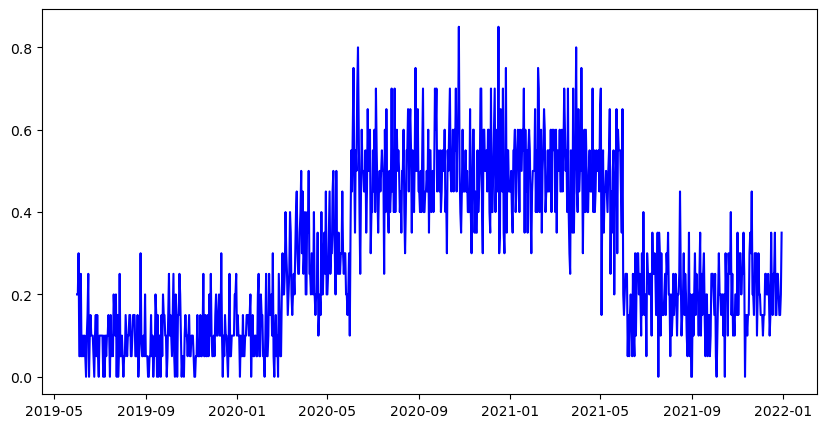

In [10]:
average_flu_symptom_prevalence = df.groupby('date')['flu_symptoms'].mean()
average_flu_symptom_prevalence = average_flu_symptom_prevalence.reset_index()
average_flu_symptom_prevalence

plt.figure(figsize=(10, 5))
plt.plot(average_flu_symptom_prevalence['date'], average_flu_symptom_prevalence['flu_symptoms'], color='blue')

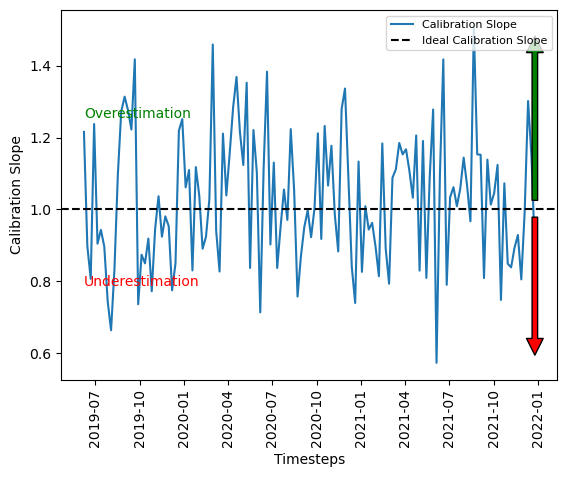

Modeling the probability that outcome==1


2020-03-31 00:00:00: Error is in the upper danger zone. 
The model has been recalibrated. 
You might want to investigate the cause of the error increasing.

2021-06-30 00:00:00: Error is in the lower danger zone. 
The model has been recalibrated. 
You might want to investigate the cause of the error increasing.

Optimization terminated successfully.
         Current function value: 0.494165
         Iterations 6

*** PRIORS ***
Intercept mean coef: -15.58 ± 0.32
age mean coef: 0.08 ± 0.00
systolic_bp mean coef: 0.08 ± 0.00


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, age, systolic_bp]


Output()

Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 80 seconds.



*** POSTERIORS ***
Intercept mean coef: -18.62 ± 0.35
age mean coef: 0.08 ± 0.00
systolic_bp mean coef: 0.08 ± 0.00


Modeling the probability that outcome==1



*** PRIORS ***
Intercept mean coef: -18.62 ± 0.35
age mean coef: 0.08 ± 0.00
systolic_bp mean coef: 0.08 ± 0.00


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, age, systolic_bp]


Output()

Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 82 seconds.



*** POSTERIORS ***
Intercept mean coef: -19.31 ± 0.38
age mean coef: 0.08 ± 0.00
systolic_bp mean coef: 0.08 ± 0.00


Modeling the probability that outcome==1



*** PRIORS ***
Intercept mean coef: -19.31 ± 0.38
age mean coef: 0.08 ± 0.00
systolic_bp mean coef: 0.08 ± 0.00


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, age, systolic_bp]


Output()

Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 180 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details



*** POSTERIORS ***
Intercept mean coef: -19.71 ± 0.36
age mean coef: 0.09 ± 0.00
systolic_bp mean coef: 0.09 ± 0.00


Modeling the probability that outcome==1



*** PRIORS ***
Intercept mean coef: -19.71 ± 0.36
age mean coef: 0.09 ± 0.00
systolic_bp mean coef: 0.09 ± 0.00


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, age, systolic_bp]


Output()

Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 76 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details



*** POSTERIORS ***
Intercept mean coef: -20.30 ± 0.38
age mean coef: 0.09 ± 0.00
systolic_bp mean coef: 0.09 ± 0.00


Modeling the probability that outcome==1



*** PRIORS ***
Intercept mean coef: -20.30 ± 0.38
age mean coef: 0.09 ± 0.00
systolic_bp mean coef: 0.09 ± 0.00


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, age, systolic_bp]


Output()

Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 87 seconds.



*** POSTERIORS ***
Intercept mean coef: -20.57 ± 0.36
age mean coef: 0.09 ± 0.00
systolic_bp mean coef: 0.09 ± 0.00


Modeling the probability that outcome==1



*** PRIORS ***
Intercept mean coef: -20.57 ± 0.36
age mean coef: 0.09 ± 0.00
systolic_bp mean coef: 0.09 ± 0.00


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, age, systolic_bp]


Output()

Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 54 seconds.



*** POSTERIORS ***
Intercept mean coef: -20.86 ± 0.32
age mean coef: 0.09 ± 0.00
systolic_bp mean coef: 0.09 ± 0.00


Modeling the probability that outcome==1



*** PRIORS ***
Intercept mean coef: -20.86 ± 0.32
age mean coef: 0.09 ± 0.00
systolic_bp mean coef: 0.09 ± 0.00


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, age, systolic_bp]


Output()

ParallelSamplingError: Chain 2 failed with: The model could not be unpickled. This is required for sampling with more than one core and multiprocessing context spawn or forkserver.

In [11]:
# get `switch_time` from the data generation code and add to a list
switch_times = []

drop_sizes = []

regular_ttd = []
static_ttd = []
spc_ttd = []
bayesian_ttd = []

def get_model_updated_log(df, model, switch_times, i):
    mytest = PREDICT(data=df, model=model, startDate='min', endDate='max', timestep='month')
    mytest.run()
    log = mytest.getLog()
    # get the first `model updated` time
    first_update_time = next(iter(log['Model Updated']))

    # calculate the time to detect (`model updated` - `switch_time`)
    time_diff = first_update_time - switch_times[i]
    ttd = abs(time_diff.days)
    del mytest
    return ttd



# run EvaluatePrediction code to get the model metrics and when calibration drops (maybe switch time from this too)
eval_model = EvaluatePredictions(colName='prediction')
mytest = PREDICT(data=df, model=eval_model, startDate='min', endDate='max', timestep='week')
mytest.addLogHook(CalibrationSlope(eval_model))
mytest.run()
log = mytest.getLog()
CalibrationSlopePlot(log)


calibration_slope_values = list(log['CalibrationSlope'].values())
# get the difference between the mean of the calibration slope values and the minimum calibration slope value for the drop size
drop_size = abs(statistics.mean(calibration_slope_values) - min(calibration_slope_values))
drop_sizes.append(drop_size)
switch_times.append(switchDate)


for i in range(0, len(switch_times)):
    # run regular testing
    ########################## Regular Testing ##########################
    model = RecalibratePredictions()
    model.trigger = TimeframeTrigger(model=model, updateTimestep=100, dataStart=df['date'].min(), dataEnd=df['date'].max())
    ttd = get_model_updated_log(df, model, switch_times, i)
    regular_ttd.append(ttd)

    ############################ Static Threshold ############################
    model = RecalibratePredictions()
    recalthreshold = 0.7 
    model.trigger = AccuracyThreshold(model=model, threshold=recalthreshold)
    ttd = get_model_updated_log(df, model, switch_times, i)
    static_ttd.append(ttd)

    ############################ SPC ############################
    model = RecalibratePredictions()
    model.trigger = SPCTrigger(model=model, input_data=df, numMonths=3)
    ttd = get_model_updated_log(df, model, switch_times, i)
    spc_ttd.append(ttd)

    ############################ Bayesian ############################
    model = BayesianModel(input_data=df, priors={"Intercept": (None), "age": (None), "systolic_bp": (None)}, cores=1, verbose=True, draws=200)
    model.trigger = BayesianRefitTrigger(model=model, input_data=df, refitFrequency=1)
    ttd = get_model_updated_log(df, model, switch_times, i)
    bayesian_ttd.append(ttd)

# plot the time to detect for all models
plt.figure(figsize=(10, 5))
plt.plot(drop_sizes, regular_ttd, color='blue', label='Regular Testing', marker='o')
plt.plot(drop_sizes, static_ttd, color='red', label='Static Threshold', marker='o')
plt.plot(drop_sizes, spc_ttd, color='green', label='SPC', marker='o')
plt.plot(drop_sizes, bayesian_ttd, color='purple', label='Bayesian', marker='o')
plt.xlabel("Drop Size / Change in Calibration Slope")
plt.ylabel("Time to Detect (days)")
plt.legend()
plt.show()
